# Mentos
Mentos is a strategy that heavily relies on factors. It also enriches data with simple momentum, industrial momentum, 52 week high.

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", color_codes=True)
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
from build import build_features
from build import build_labels
from build import build_train_test
from backtest import backtest_report

In [3]:
# select stocks with market cap > 16 million, trading price > 5 as stock universe
raw = pd.read_parquet("../data/raw-0.1.parquet")
gvkeys = raw[(raw.mcap > 1e6) & (raw.prccd > 5)].index.get_level_values("gvkey").unique()
universe = raw.loc[gvkeys]

## Regression

In [4]:
features = build_features(universe, mentos, scale=None)

NameError: name 'mentos' is not defined

In [42]:
labels = build_labels(universe, months=3, relative=True)

In [43]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2012-01-01",
    test_start="2012-01-01",
    test_end="2016-01-01",
    method="regression",
    extreme=False)

In [44]:
def r2(y_true, y_pred):
    r2 = 1 - np.sum((y_true - y_pred) ** 2)/np.sum(y_true ** 2)
    return r2

r2_score = make_scorer(r2)

In [45]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_reg.fit(X_train, y_train)
train_score = r2_score(xgb_reg, X_train, y_train)
test_score = r2_score(xgb_reg, X_test, y_test)
print(f"R2 on training set: {train_score}\nR2 on test set: {test_score}")

R2 on training set: 0.15611363242673104
R2 on test set: -0.01328760653389649


In [46]:
data=pd.read_parquet("../data/backtest_5-0.1.parquet")

Short positon sharpe ratio: 1.0686509093891197
Neutral positon sharpe ratio: 0.8371147274324102
Long positon sharpe ratio: -0.08480728005427972


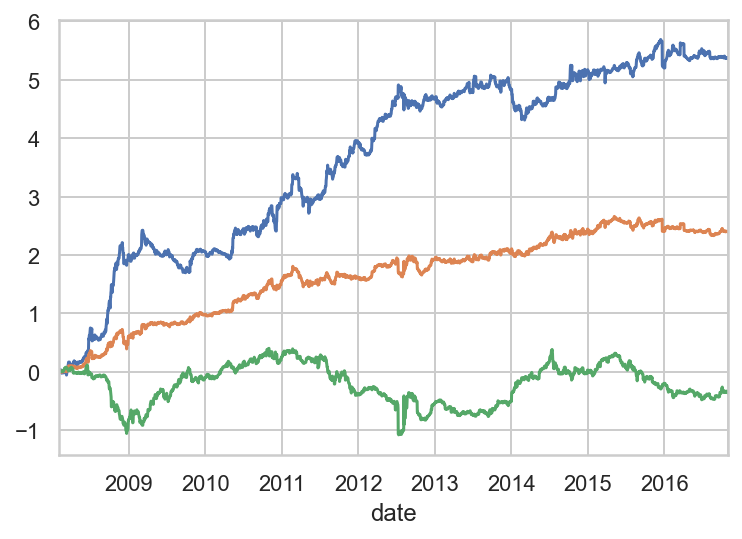

In [47]:
backtest_report(
    data,
    features,
    xgb_reg,
    test_start="2012-01-01",
    test_end="2016-01-01",
    months=3,
    n=10,
    weight="equal")

## Binary Classification

In [48]:
features = build_features(universe, mentos, scale=None)

In [49]:
labels = build_labels(universe, months=3, relative=True)

In [50]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2012-01-01",
    test_start="2012-01-01",
    test_end="2016-01-01",
    method="binary",
    thres=0.1, 
    extreme=False)

Classification report on training set:

              precision    recall  f1-score   support

           0       0.61      0.57      0.59     32731
           1       0.60      0.65      0.63     33382

    accuracy                           0.61     66113
   macro avg       0.61      0.61      0.61     66113
weighted avg       0.61      0.61      0.61     66113

Classification report on test set:

              precision    recall  f1-score   support

           0       0.51      0.53      0.52     40477
           1       0.57      0.54      0.56     45663

    accuracy                           0.54     86140
   macro avg       0.54      0.54      0.54     86140
weighted avg       0.54      0.54      0.54     86140



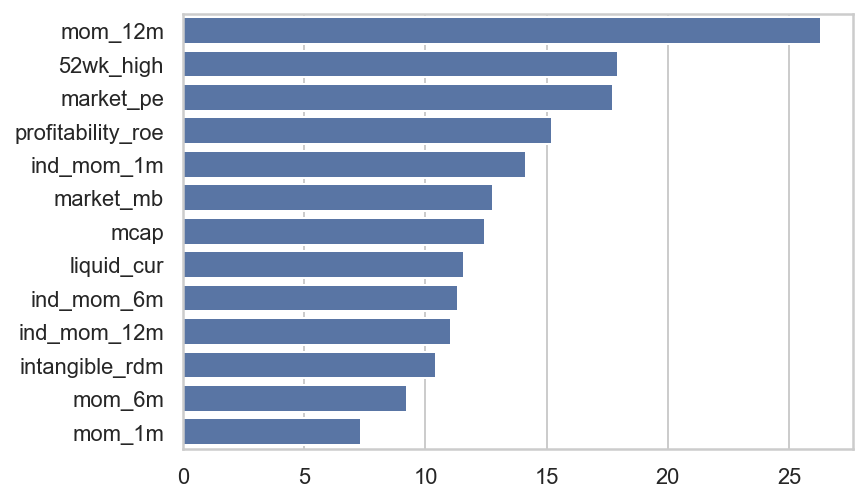

In [51]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short positon sharpe ratio: 1.0693040579570061
Neutral positon sharpe ratio: 1.0550682512826401
Long positon sharpe ratio: 0.28242467321707193


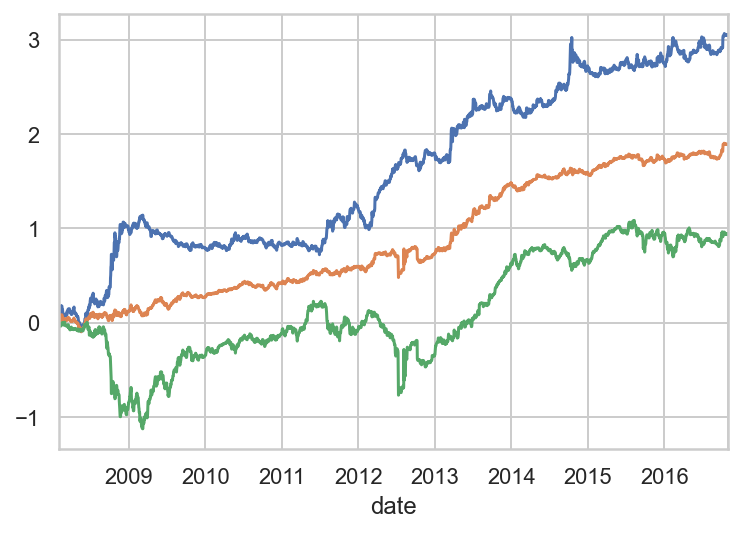

In [52]:
backtest_report(
    data,
    features,
    xgb_clf,
    test_start="2008-01-01",
    test_end="2016-01-01",
    months=3,
    n=10,
    weight="equal")

## Multi Classification

In [56]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2012-01-01",
    test_start="2012-01-01",
    test_end="2016-01-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.63      0.61      0.62     15937
           0       1.00      0.00      0.01      2595
           1       0.61      0.73      0.66     17156

    accuracy                           0.62     35688
   macro avg       0.75      0.45      0.43     35688
weighted avg       0.65      0.62      0.60     35688

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.23      0.46      0.31     10627
           0       0.83      0.00      0.00     38876
           1       0.23      0.70      0.35     13613

    accuracy                           0.23     63116
   macro avg       0.43      0.39      0.22     63116
weighted avg       0.60      0.23      0.13     63116



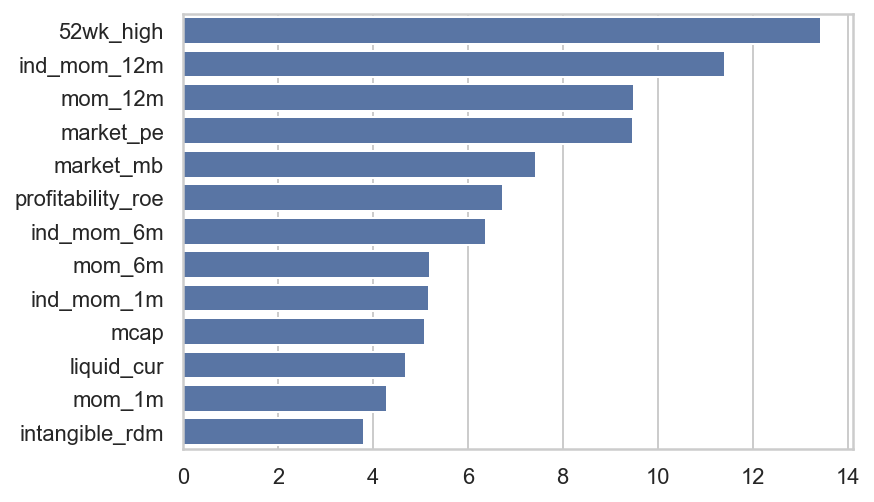

In [57]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short positon sharpe ratio: 1.3520698569823055
Neutral positon sharpe ratio: 2.1484401674047136
Long positon sharpe ratio: 1.3344709943954274


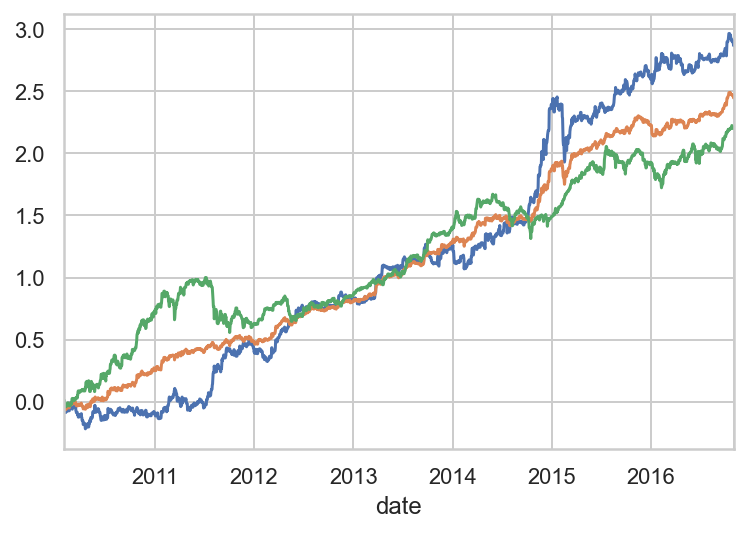

In [58]:
backtest_report(
    data,
    features,
    xgb_clf,
    test_start="2012-01-01",
    test_end="2016-01-01",
    months=3,
    n=10,
    weight="equal")